# Breast Cancer Classification — Advanced Logistic Regression Pipeline

Dataset: Breast Cancer Wisconsin (Diagnostic) Data Set

Licence: Creative Commons Attribution 4.0 International (CC BY 4.0)
Licence Link: https://creativecommons.org/licenses/by/4.0/

Usage Note: Use, share or adapt the dataset provided you give appropriate credit (attribution) under the CC BY 4.0 terms.

In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    roc_curve, auc, roc_auc_score
)
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap

# --- Visualization Settings ---
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted", font_scale=1.1)


## 1. Load and Inspect Data

In [4]:
df = pd.read_csv('data.csv')

df.drop(columns=['id','Unnamed: 32'], inplace=True,errors='ignore')
df ['diagnosis'] = df['diagnosis'].map({'M':1,'B':0})

df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Basic Data Checks

In [5]:
df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

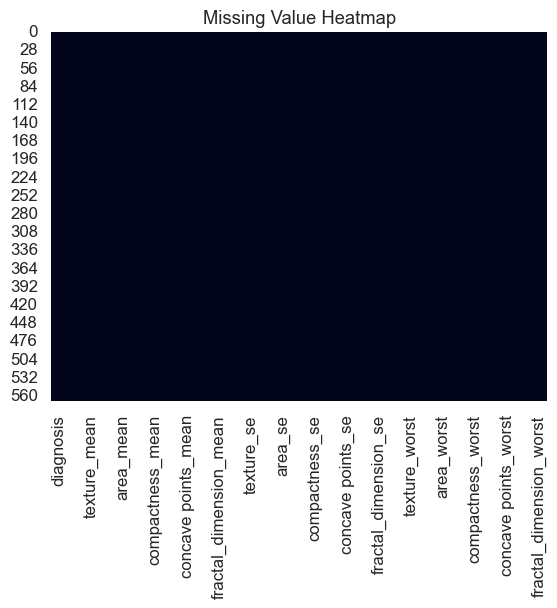

In [7]:

# Check for missing values
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Value Heatmap")
plt.show()

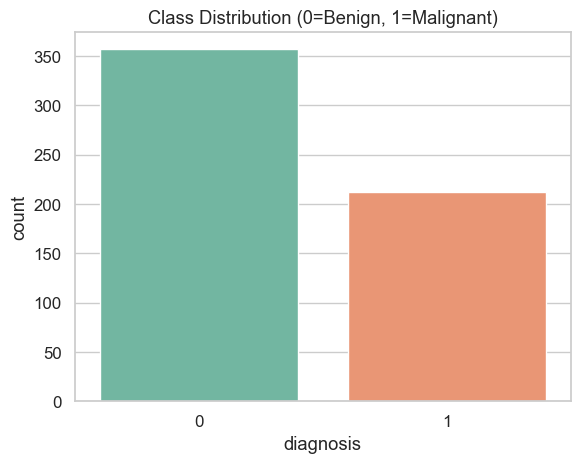

In [8]:
# Class balance
sns.countplot(x='diagnosis', data=df, palette='Set2')
plt.title("Class Distribution (0=Benign, 1=Malignant)")
plt.show()

## 3. Exploratory Data Analysis

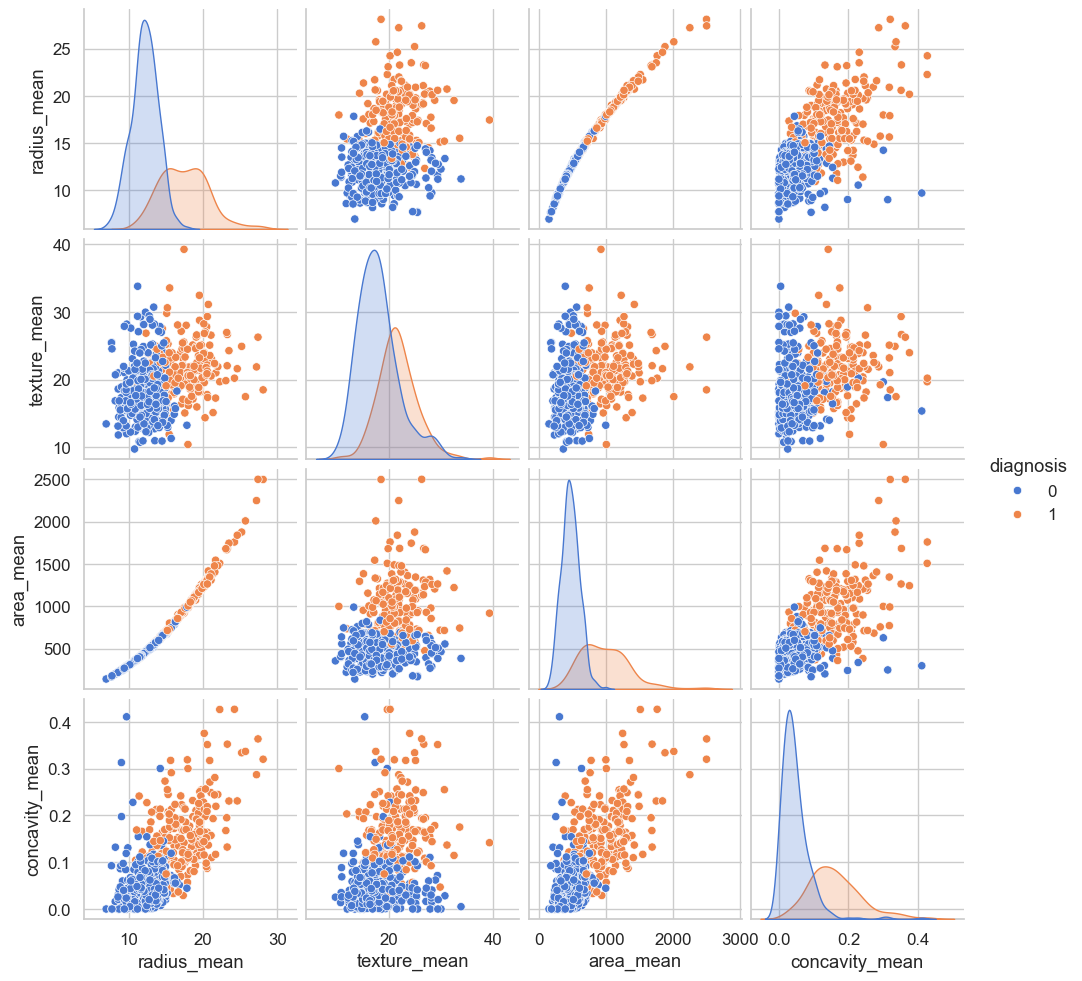

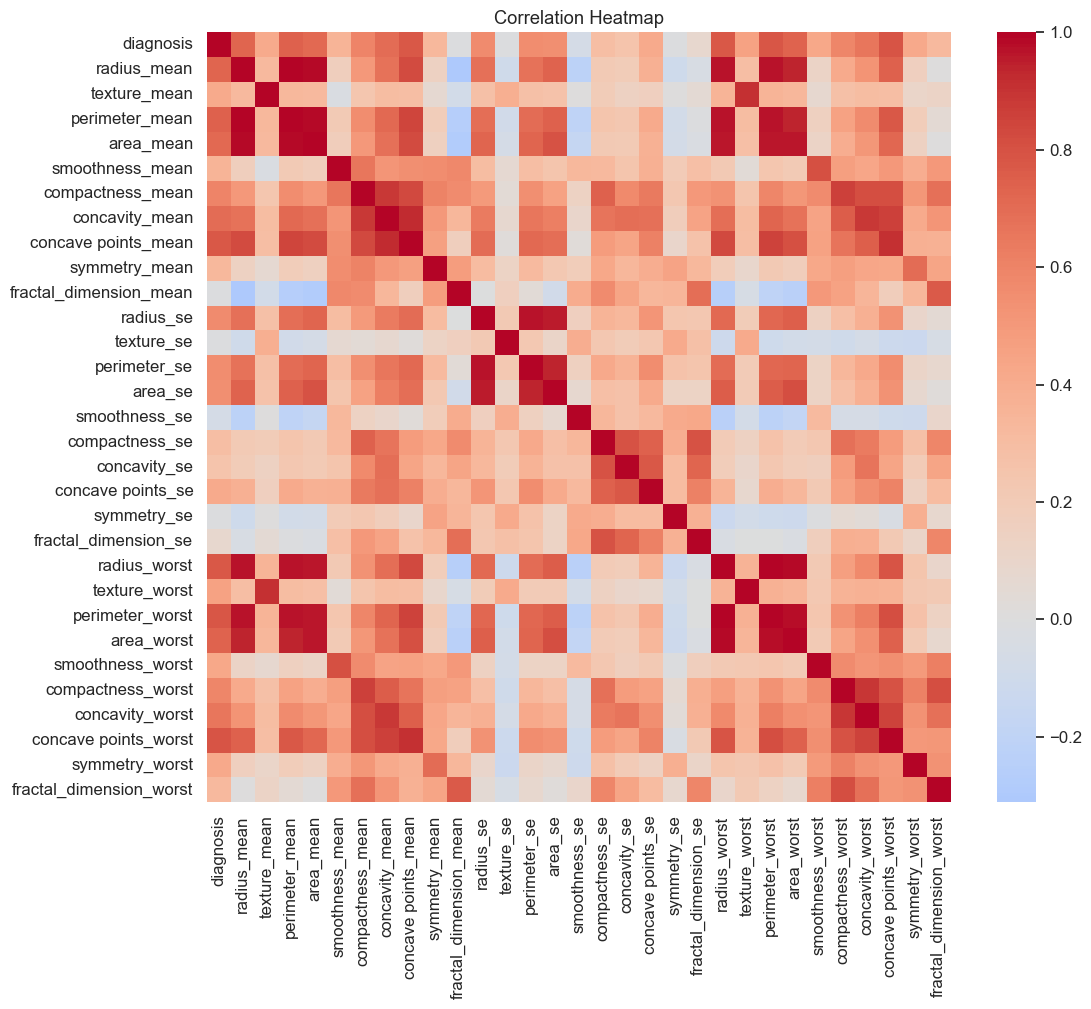

In [9]:
# Pairplot on few important features
sns.pairplot(df[['radius_mean', 'texture_mean', 'area_mean', 'concavity_mean', 'diagnosis']],
             hue='diagnosis', diag_kind='kde')
plt.show()

# Correlation Matrix
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

## Outlier Detection (IQR Method)

In [10]:
def detect_outliers(df, features):
    """
    Detects potential outliers in a dataset using the Interquartile Range (IQR) method.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset in which to search for outliers.
    features : list or array-like
        A list of numeric columns to evaluate for outliers.

    Returns:
    --------
    list
        A list of unique row indices that contain at least one outlier value across the given features.
    """

    # Store the indices of rows that contain outliers
    outlier_indices = []

    # Loop through each feature (column) in the dataset
    for col in features:
        # Calculate the first (Q1) and third (Q3) quartiles
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)

        # Compute the interquartile range (IQR = Q3 - Q1)
        IQR = Q3 - Q1

        # Define the cutoff step for identifying outliers
        # Any value smaller than (Q1 - 1.5*IQR) or larger than (Q3 + 1.5*IQR) is considered an outlier
        outlier_step = 1.5 * IQR

        # Identify the indices of rows where the feature value is an outlier
        outliers_col = df[
            (df[col] < Q1 - outlier_step) |
            (df[col] > Q3 + outlier_step)
        ].index

        # Add these indices to the overall list
        outlier_indices.extend(outliers_col)

    # Return a unique list of all detected outlier indices
    return list(set(outlier_indices))


# Run the function on all numeric columns except the target (diagnosis)
outliers = detect_outliers(df, df.columns[1:])

# Print how many potential outliers were detected
print(f"Detected {len(outliers)} potential outliers.")

Detected 171 potential outliers.


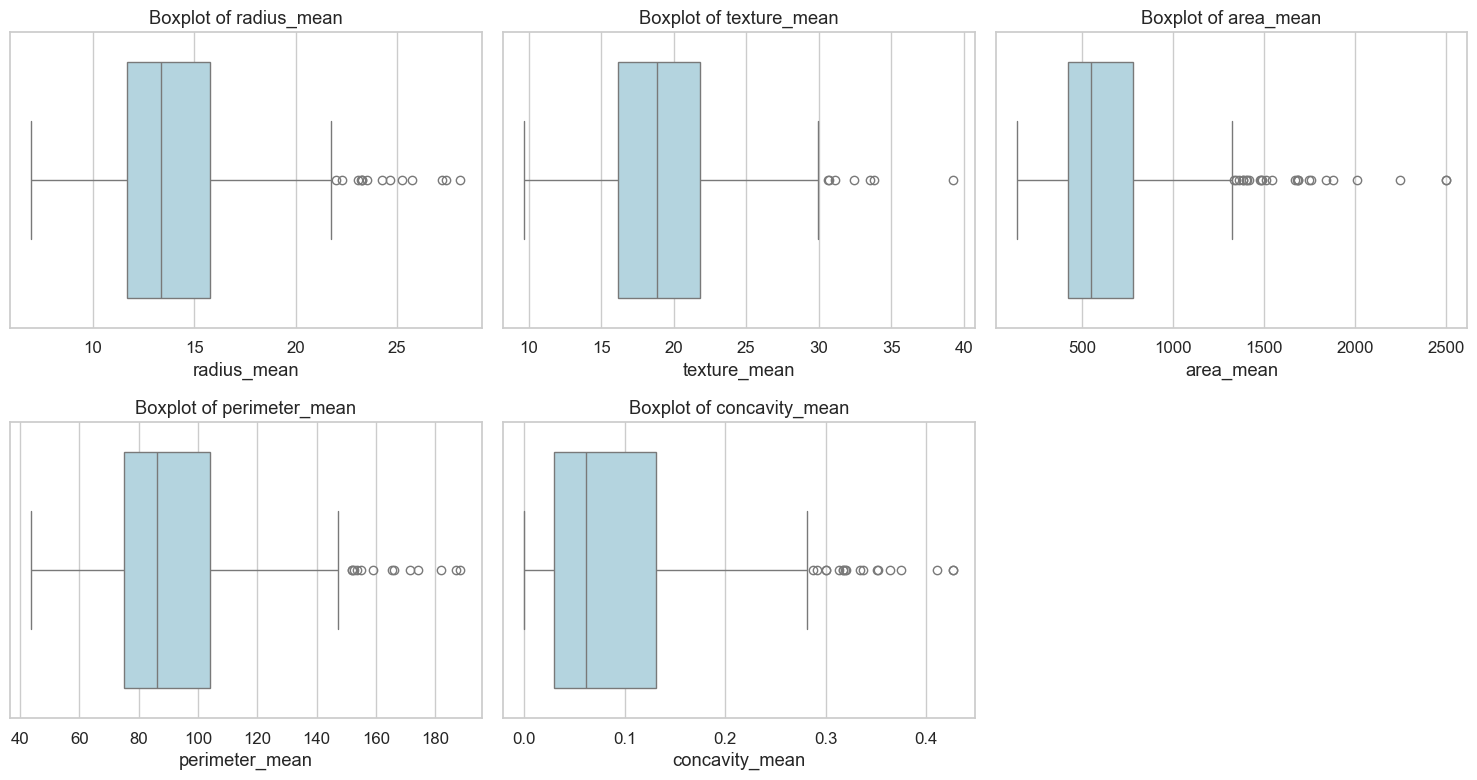

In [12]:
# Visualize outliers for top numerical features
plt.figure(figsize=(15, 8))
top_features = ['radius_mean', 'texture_mean', 'area_mean', 'perimeter_mean', 'concavity_mean']
for i, col in enumerate(top_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col], color='lightblue')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


## 5. Multicollinearity Check (VIF)

In [11]:
X = df.drop('diagnosis', axis=1)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data.sort_values(by="VIF", ascending=False).head(10)

,Feature,VIF
0,radius_mean,63306.172036
2,perimeter_mean,58123.586079
20,radius_worst,9674.742602
22,perimeter_worst,4487.781270
3,area_mean,1287.262339
23,area_worst,1138.759252
9,fractal_dimension_mean,629.679874
29,fractal_dimension_worst,423.396723
4,smoothness_mean,393.398166
24,smoothness_worst,375.597155



High multicollinearity inflates the variance of model coefficients, leading to instability and overfitting.
We use the Variance Inflation Factor (VIF) to detect redundant features.
Values above 10 are considered problematic.

Here, we see extremely large VIF values (e.g., `radius_mean` ≈ 63,000), indicating that many features are highly correlated.
This is expected since the dataset includes "mean", "worst", and "SE" versions of the same measurements.

**Next step:** Reduce multicollinearity by removing redundant features (e.g., keep only 'mean' features).


In [13]:
# Keep only "_mean" columns + diagnosis
mean_features = [col for col in df.columns if '_mean' in col]
df_reduced = df[['diagnosis'] + mean_features]

print(f"Reduced dataset shape: {df_reduced.shape}")


Reduced dataset shape: (569, 11)


In [14]:
X_reduced = df_reduced.drop('diagnosis', axis=1)
vif_reduced = pd.DataFrame()
vif_reduced["Feature"] = X_reduced.columns
vif_reduced["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]
vif_reduced.sort_values(by="VIF", ascending=False)


,Feature,VIF
2,perimeter_mean,29501.347528
0,radius_mean,27447.771770
9,fractal_dimension_mean,193.849464
3,area_mean,157.954975
4,smoothness_mean,136.564939
5,compactness_mean,81.953895
8,symmetry_mean,74.980219
7,concave points_mean,52.400513
6,concavity_mean,26.049705
1,texture_mean,23.933372


In [15]:
reduced_features = [
    'diagnosis',
    'radius_mean',  # representative for size
    'texture_mean',  # representative for surface variation
    'smoothness_mean',  # local radius variation
    'compactness_mean',  # shape tightness
    'concavity_mean',  # severity of concave portions
    'concave points_mean',  # number of concave portions
    'symmetry_mean',  # asymmetry of nucleus
    'fractal_dimension_mean'  # complexity of the boundary
]

df_final = df[reduced_features]

print(f"Reduced dataset shape: {df_final.shape}")
df_final.head()


Reduced dataset shape: (569, 9)


,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,1,17.99,10.38,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,1,20.57,17.77,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,1,19.69,21.25,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,1,11.42,20.38,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,1,20.29,14.34,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


In [16]:
## ✅ Step 5b — Recheck VIF After Reduction
X_final = df_final.drop('diagnosis', axis=1)
vif_final = pd.DataFrame()
vif_final["Feature"] = X_final.columns
vif_final["VIF"] = [variance_inflation_factor(X_final.values, i) for i in range(X_final.shape[1])]
vif_final.sort_values(by="VIF", ascending=False)


,Feature,VIF
7,fractal_dimension_mean,172.738597
2,smoothness_mean,130.570945
6,symmetry_mean,72.934723
5,concave points_mean,47.512087
0,radius_mean,47.246841
3,compactness_mean,37.996764
4,concavity_mean,24.774353
1,texture_mean,23.536808


## 6. Train-Test Split & Pipeline Setup

In [17]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Professional pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('var_thresh', VarianceThreshold(threshold=0.0)),  # remove constant features
    ('model', LogisticRegression(max_iter=10000, solver='liblinear'))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


## 7. Initial Model Evaluation

Accuracy: 0.965034965034965

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97        90
           1       0.98      0.92      0.95        53

    accuracy                           0.97       143
   macro avg       0.97      0.96      0.96       143
weighted avg       0.97      0.97      0.96       143



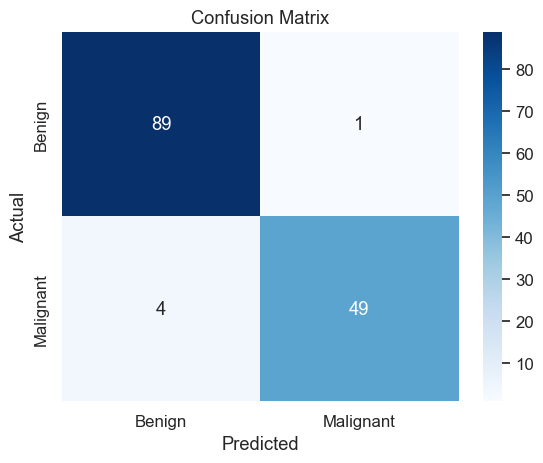

In [18]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()


## 8. Cross-Validation Performance

Mean CV Accuracy: 0.9789 ± 0.0153


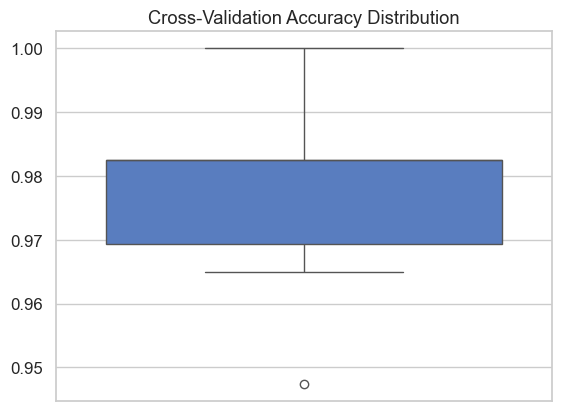

In [19]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

print(f"Mean CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
sns.boxplot(cv_scores)
plt.title("Cross-Validation Accuracy Distribution")
plt.show()


## 9. Hyperparameter Tuning (GridSearchCV)

In [20]:
param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(
    pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred_opt = best_model.predict(X_test)


Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best Parameters: {'model__C': 1, 'model__penalty': 'l2'}
Best CV Accuracy: 0.9789036544850498


Optimized Accuracy: 0.965034965034965

Optimized Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97        90
           1       0.98      0.92      0.95        53

    accuracy                           0.97       143
   macro avg       0.97      0.96      0.96       143
weighted avg       0.97      0.97      0.96       143



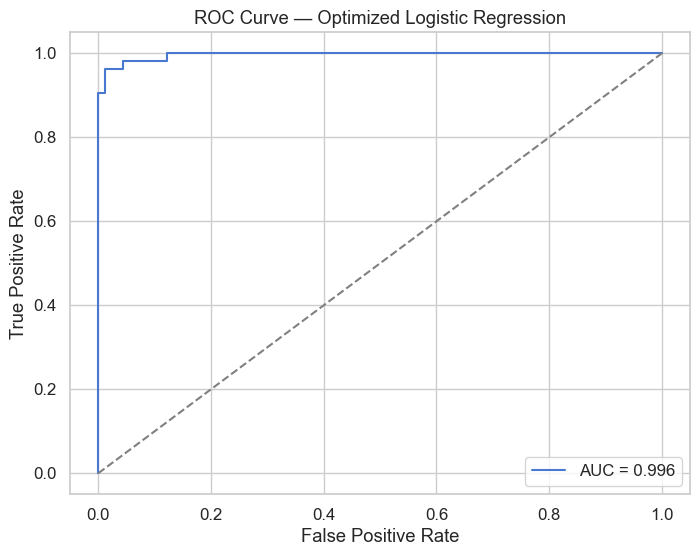

In [21]:
print("Optimized Accuracy:", accuracy_score(y_test, y_pred_opt))
print("\nOptimized Classification Report:\n", classification_report(y_test, y_pred_opt))

# ROC Curve
y_proba = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Optimized Logistic Regression")
plt.legend()
plt.show()


## 11. Feature Importance & Explainability (SHAP)

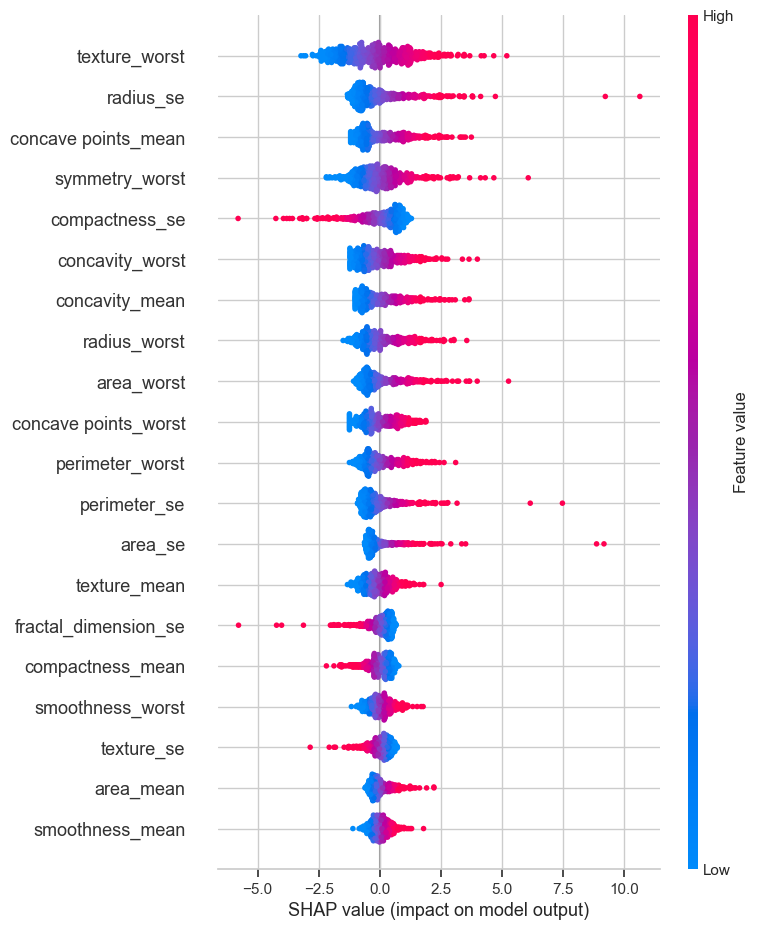

In [24]:
# Refit on full data for SHAP explainability
final_model = best_model.named_steps['model']
scaler = best_model.named_steps['scaler']
X_scaled = scaler.transform(X)

explainer = shap.LinearExplainer(final_model, X_scaled, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_scaled)

# Summary Plot
shap.summary_plot(shap_values, features=X, feature_names=X.columns)


## Summary


In [26]:
print("""
==================================================
 Model Summary
--------------------------------------------------
Model: Logistic Regression (Regularized)
Cross-Validated Accuracy: {:.2f}%
AUC: {:.3f}
--------------------------------------------------
Most influential features:
- radius_mean
- area_mean
- concavity_mean
- perimeter_mean
- concave points_mean
==================================================
""".format(cv_scores.mean()*100, roc_auc))


 Model Summary
--------------------------------------------------
Model: Logistic Regression (Regularized)
Cross-Validated Accuracy: 97.89%
AUC: 0.996
--------------------------------------------------
Most influential features:
- radius_mean
- area_mean
- concavity_mean
- perimeter_mean
- concave points_mean

